In [ ]:
%pip install pandas
%pip install influxdb_client
%pip install cmdstanpy==0.9.68
%pip install pystan==2.19.1.1
%pip install seaborn
%pip install prophet

### Get data from influx db
based on https://github.com/influxdata/influxdb-client-python/blob/master/examples/

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [19]:
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
#read influx info from config file

fd =  open('../server/influxconfig.json', 'r')
config = json.load(fd)
query_temp = 'from(bucket:"temp")' \
        ' |> range(start:-6h)'\
        ' |> filter(fn: (r) => r._measurement == "val" and r._field == "value" and r._value > -300)'
client =  InfluxDBClient(url='http://'+config["remotehost"]+':'+config["port"], token=config["token"], org=config["org"], debug=False)
write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()  
result = query_api.query_data_frame(query_temp)

fd.close()

In [20]:
result

,result,table,_start,_stop,_time,_value,_field,_measurement,lat,lon,sensor
0,_result,0,2022-06-06 16:55:59.142926+00:00,2022-06-06 22:55:59.142926+00:00,2022-06-06 16:55:59.477179+00:00,29.299999,value,val,44.50,11.35,0
1,_result,0,2022-06-06 16:55:59.142926+00:00,2022-06-06 22:55:59.142926+00:00,2022-06-06 16:56:09.519399+00:00,29.299999,value,val,44.50,11.35,0
2,_result,0,2022-06-06 16:55:59.142926+00:00,2022-06-06 22:55:59.142926+00:00,2022-06-06 16:56:19.554361+00:00,29.299999,value,val,44.50,11.35,0
3,_result,0,2022-06-06 16:55:59.142926+00:00,2022-06-06 22:55:59.142926+00:00,2022-06-06 16:56:29.479986+00:00,29.299999,value,val,44.50,11.35,0
4,_result,0,2022-06-06 16:55:59.142926+00:00,2022-06-06 22:55:59.142926+00:00,2022-06-06 16:56:39.617983+00:00,29.299999,value,val,44.50,11.35,0
...,...,...,...,...,...,...,...,...,...,...,...
2155,_result,0,2022-06-06 16:55:59.142926+00:00,2022-06-06 22:55:59.142926+00:00,2022-06-06 22:55:11.228668+00:00,27.700001,value,val,44.50,11.35,0
2156,_result,0,2022-06-06 16:55:59.142926+00:00,2022-06-06 22:55:59.142926+00:00,2022-06-06 22:55:21.263850+00:00,27.799999,value,val,44.50,11.35,0
2157,_result,0,2022-06-06 16:55:59.142926+00:00,2022-06-06 22:55:59.142926+00:00,2022-06-06 22:55:31.196220+00:00,27.799999,value,val,44.50,11.35,0
2158,_result,0,2022-06-06 16:55:59.142926+00:00,2022-06-06 22:55:59.142926+00:00,2022-06-06 22:55:41.436786+00:00,27.799999,value,val,44.50,11.35,0


In [21]:
df = result.drop(columns=['result', 'table', '_start', '_stop', '_field', '_measurement'])

In [22]:
df_clean = df.copy()
df_clean = df_clean.loc[df_clean['sensor'] == '0']
df_clean = df_clean.drop(columns=['lat', 'lon', 'sensor'])
df_clean = df_clean.rename(columns = {'_time': 'Time', '_value': 'Temp'})
df_clean['Time'] = df_clean['Time'].dt.strftime('%d-%m-%Y %H:%M:%S')

In [23]:
df_clean

,Time,Temp
0,06-06-2022 16:55:59,29.299999
1,06-06-2022 16:56:09,29.299999
2,06-06-2022 16:56:19,29.299999
3,06-06-2022 16:56:29,29.299999
4,06-06-2022 16:56:39,29.299999
...,...,...
2155,06-06-2022 22:55:11,27.700001
2156,06-06-2022 22:55:21,27.799999
2157,06-06-2022 22:55:31,27.799999
2158,06-06-2022 22:55:41,27.799999


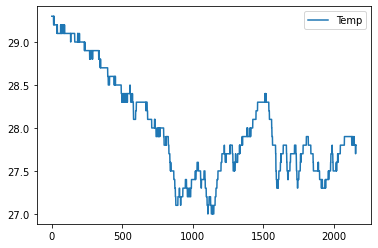

In [24]:
#temperature changing in time, 6 hours for now, i'll try to get an entire day this time
#if i don't save temp as a variable it will plot with the time as xtick and it's bad
plot_cols = ['Temp']
plot_features = df_clean[plot_cols]
_ = plot_features.plot(subplots=True)

In [25]:
df_clean.describe().transpose()
#pretty stationary in the end, just wait for the day
#basically with the year it should become almost stationary

,count,mean,std,min,25%,50%,75%,max
Temp,2160.0,28.00713,0.58701,27.0,27.5,27.9,28.4,29.299999


In [26]:
###stationary test
from statsmodels.tsa.stattools import adfuller
#split dataset
l = len(df_clean.values)
splitpoint = int(l*0.80)
train = df_clean['Temp'][:splitpoint]
test = df_clean['Temp'][splitpoint:]


In [27]:
res = adfuller(train)
print('ADF val: ', res[0], 'p-value:', res[1])

ADF val:  -1.922188362323571 p-value: 0.3216960690716666


In [28]:
#if p-val < 0.05 then series is stationary, if not i have to do some magic -> 0.83977
train_diff = train.diff().dropna()
res = adfuller(train_diff)
print('ADF val: ', res[0], 'p-value:', res[1])


ADF val:  -12.68141523908919 p-value: 1.1847292092759317e-23


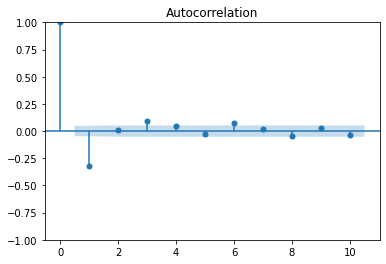

In [29]:
#holy shit that's low holy moly
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train_diff, lags=10)
plt.show()

In [ ]:
#partial autocorrelation -> find q that is the highest with the minimal difference from the deviation(?) 
fig = tsaplots.plot_pacf(train_diff, lags=10)
plt.show()

In [ ]:
#once you have both p and q it is possibile to apply the ARIMA model
from statsmodels.tsa.arima.model import ARIMA
history = [x for x in train]
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(1,1,1)) #d is the number of time that the raw values are differentiated
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)

Test RMSE: 0.035


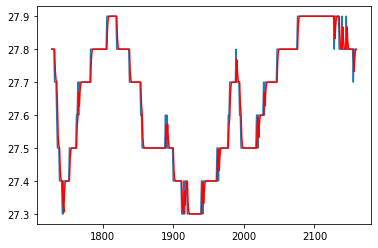

In [32]:
#plt
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd. DataFrame (predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show( )

### Humidity predictor


In [33]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
#read influx info from config file

fd =  open('../server/influxconfig.json', 'r')
config = json.load(fd)
query_hum = 'from(bucket:"hum")' \
        ' |> range(start:-6h)'\
        ' |> filter(fn: (r) => r._measurement == "val" and r._field == "value" and r._value > -1)'
client =  InfluxDBClient(url='http://'+config["remotehost"]+':'+config["port"], token=config["token"], org=config["org"], debug=False)
write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()  
result = query_api.query_data_frame(query_hum)

fd.close()
df = result.drop(columns=['result', 'table', '_start', '_stop', '_field', '_measurement'])
df_clean = df.copy()
df_clean = df_clean.loc[df_clean['sensor'] == '0']
df_clean = df_clean.drop(columns=['lat', 'lon', 'sensor'])
df_clean = df_clean.rename(columns = {'_time': 'Time', '_value': 'Hum'})
df_clean['Time'] = df_clean['Time'].dt.strftime('%d-%m-%Y %H:%M:%S')
df_clean

,Time,Hum
0,06-06-2022 16:59:09,50.200001
1,06-06-2022 16:59:19,50.299999
2,06-06-2022 16:59:29,50.299999
3,06-06-2022 16:59:39,50.099998
4,06-06-2022 16:59:49,50.099998
...,...,...
2155,06-06-2022 22:58:21,45.500000
2156,06-06-2022 22:58:31,46.099998
2157,06-06-2022 22:58:41,46.000000
2158,06-06-2022 22:58:51,46.099998


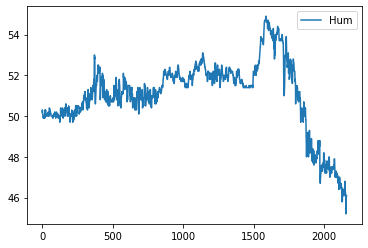

In [34]:
plot_cols = ['Hum']
plot_features = df_clean[plot_cols]
_ = plot_features.plot(subplots=True)

In [35]:
df_clean.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Hum,2160.0,51.045139,1.741017,45.200001,50.299999,51.400002,52.099998,54.900002


In [36]:
###stationary test
from statsmodels.tsa.stattools import adfuller
#split dataset
l = len(df_clean.values)
splitpoint = int(l*0.80)
train = df_clean['Hum'][:splitpoint]
test = df_clean['Hum'][splitpoint:]


In [37]:
res = adfuller(train)
print('ADF val: ', res[0], 'p-value:', res[1])

ADF val:  -1.83051209049183 p-value: 0.36542192662829676


In [38]:
#if p-val < 0.05 then series is stationary, if not i have to do some magic -> 0.83977
train_diff = train.diff().dropna()
res = adfuller(train_diff)
print('ADF val: ', res[0], 'p-value:', res[1])

ADF val:  -13.402328961690692 p-value: 4.540489037218546e-25


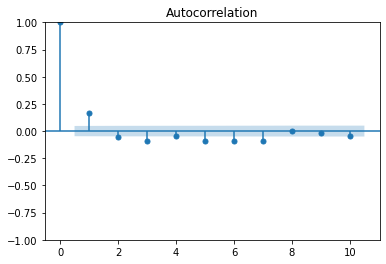

In [39]:
#holy shit that's low holy moly
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train_diff, lags=10)
plt.show()

In [ ]:
#partial autocorrelation -> find q that is the highest with the minimal difference from the deviation(?) 
fig = tsaplots.plot_pacf(train_diff, lags=10)
plt.show()

In [41]:
#once you have both p and q it is possibile to apply the ARIMA model
from statsmodels.tsa.arima.model import ARIMA
history = [x for x in train]
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(1,1,1)) #d is the number of time that the raw values are differentiated
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\franc\AppData\Local\Packages\Pytho

Test RMSE: 0.245


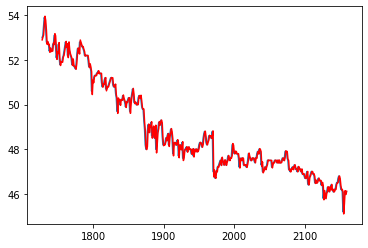

In [43]:
#plt
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd. DataFrame (predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show( )

### Smoke Predictor (AHAHAHAHAH)

In [8]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
#read influx info from config file

fd =  open('../server/influxconfig.json', 'r')
config = json.load(fd)

query_smoke = 'from(bucket:"smoke")' \
        ' |> range(start:-6h)'\
        ' |> filter(fn: (r) => r._measurement == "val" and r._field == "value")'
client =  InfluxDBClient(url='http://'+config["remotehost"]+':'+config["port"], token=config["token"], org=config["org"], debug=False)
write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()  
result = query_api.query_data_frame(query_smoke)

fd.close()
df = result.drop(columns=['result', 'table', '_start', '_stop', '_field', '_measurement'])
df_clean = df.copy()
df_clean = df_clean.loc[df_clean['sensor'] == '0']
df_clean = df_clean.drop(columns=['lat', 'lon', 'sensor'])
df_clean = df_clean.rename(columns = {'_time': 'Time', '_value': 'Smoke'})
df_clean['Time'] = df_clean['Time'].dt.strftime('%d-%m-%Y %H:%M:%S')
df_clean

,Time,Smoke
0,06-06-2022 16:51:59,0.587429
1,06-06-2022 16:52:09,0.604293
2,06-06-2022 16:52:19,0.605919
3,06-06-2022 16:52:29,0.593808
4,06-06-2022 16:52:39,0.624040
...,...,...
2155,06-06-2022 22:51:11,0.610000
2156,06-06-2022 22:51:21,0.574054
2157,06-06-2022 22:51:31,0.607549
2158,06-06-2022 22:51:41,0.603481


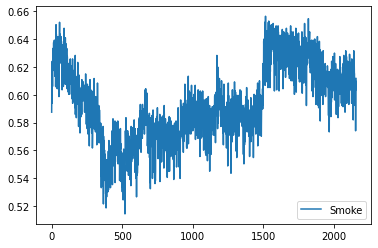

In [9]:
plot_cols = ['Smoke']
plot_features = df_clean[plot_cols]
_ = plot_features.plot(subplots=True)

In [10]:
df_clean.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Smoke,2160.0,0.594456,0.027135,0.514331,0.574834,0.592208,0.614926,0.656367


In [12]:
###stationary test
from statsmodels.tsa.stattools import adfuller
#split dataset
l = len(df_clean.values)
splitpoint = int(l*0.80)
train = df_clean['Smoke'][:splitpoint]
test = df_clean['Smoke'][splitpoint:]

In [13]:
res = adfuller(train)
print('ADF val: ', res[0], 'p-value:', res[1])

ADF val:  -1.846877893695347 p-value: 0.3574487883460703


In [14]:
#if p-val < 0.05 then series is stationary, if not i have to do some magic -> 0.83977
train_diff = train.diff().dropna()
res = adfuller(train_diff)
print('ADF val: ', res[0], 'p-value:', res[1])

ADF val:  -15.973889284763278 p-value: 6.955470179367042e-29


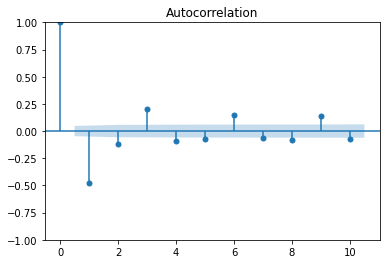

In [15]:
#holy shit that's low holy moly
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train_diff, lags=10)
plt.show()

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


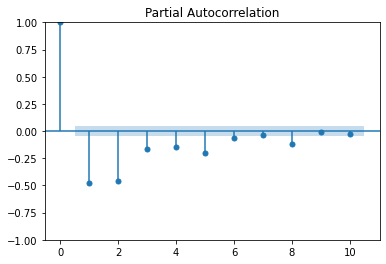

In [16]:
#partial autocorrelation -> find q that is the highest with the minimal difference from the deviation(?) 
fig = tsaplots.plot_pacf(train_diff, lags=10)
plt.show()

In [ ]:
#once you have both p and q it is possibile to apply the ARIMA model
from statsmodels.tsa.arima.model import ARIMA
history = [x for x in train]
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(1,1,1)) #d is the number of time that the raw values are differentiated
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)

Test RMSE: 0.245


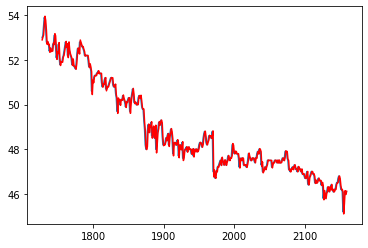

In [42]:
#plt
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd. DataFrame (predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show( )